Code used to expiriment with Q-learning and provide avg rewards per episode plots| Task 1 and 2


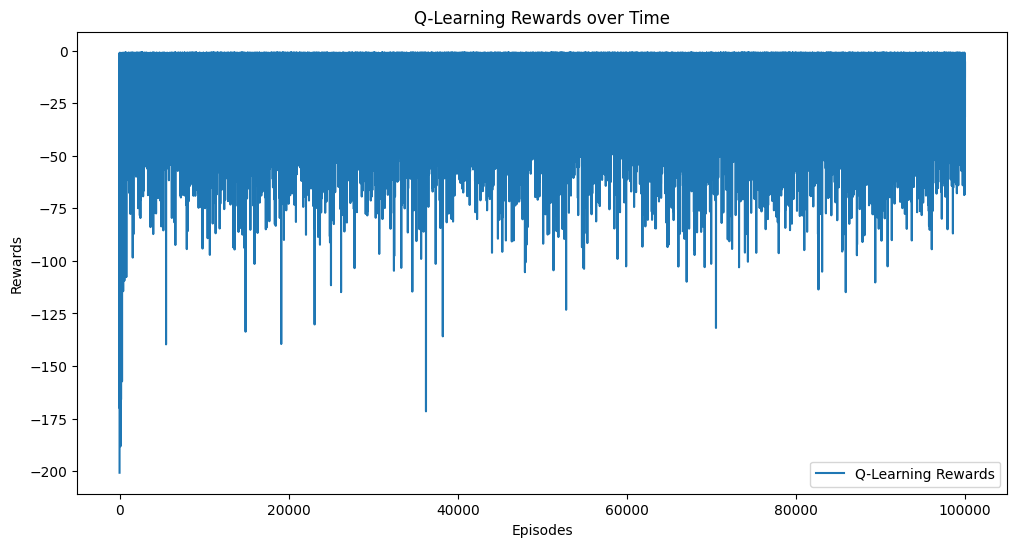

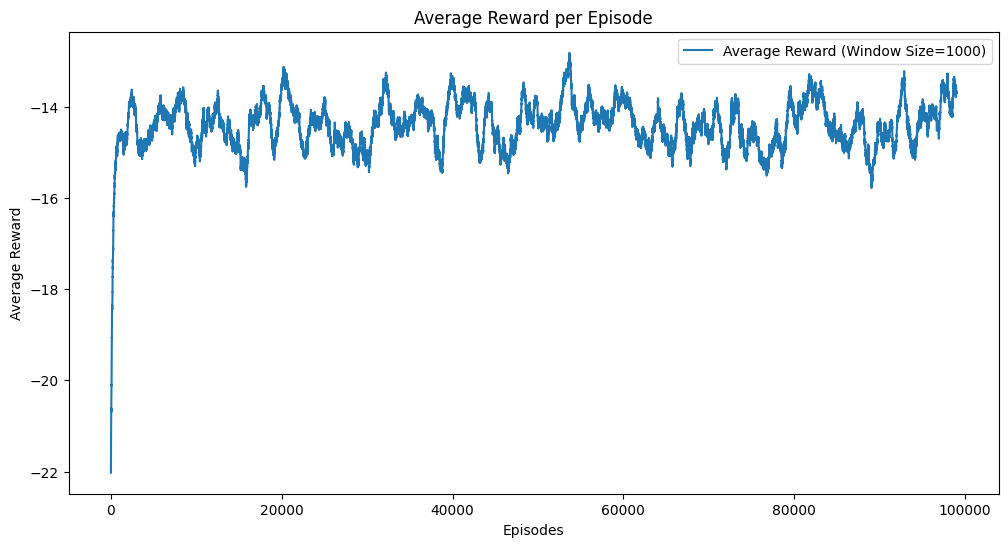

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

class VNFEnvironment:
    def __init__(self, M, N, C, trans_probs, w_on, w_r, w_SLA, cost_on, cost_r, cost_SLA):
        self.M = M  # Number of Physical Nodes
        self.N = N  # Number of VNFs
        self.C = C  # Capacity of Node
        self.trans_probs = trans_probs  # Transition Probabilities
        self.w_on = w_on  # Weight of power cost
        self.w_r = w_r  # Weight of reconfiguration cost
        self.w_SLA = w_SLA  # Weight of SLA cost
        self.cost_on = cost_on  # Power cost
        self.cost_r = cost_r  # Reconfiguration cost
        self.cost_SLA = cost_SLA  # SLA violation cost

        self.state = {
            'locations': np.random.choice(range(self.M), self.N),
            'demands': np.random.choice(['H', 'L'], self.N)
        }

        self.state_to_index_map = {}
        self.index_to_state_map = {}
        self._generate_state_mappings()

    def _generate_state_mappings(self):
        state_idx = 0
        for locations in itertools.product(range(self.M), repeat=self.N):
            for demands in itertools.product(['H', 'L'], repeat=self.N):
                state = {'locations': list(locations), 'demands': list(demands)}
                self.state_to_index_map[self._state_to_tuple(state)] = state_idx
                self.index_to_state_map[state_idx] = state
                state_idx += 1

    def _state_to_tuple(self, state):
        return (tuple(state['locations']), tuple(state['demands']))

    def state_to_index(self, state):
        return self.state_to_index_map[self._state_to_tuple(state)]

    def index_to_state(self, index):
        return self.index_to_state_map[index]

    def reset(self):
        self.state = {
            'locations': np.random.choice(range(self.M), self.N),
            'demands': np.random.choice(['H', 'L'], self.N)
        }
        return self.state

    def next_step(self, state, action):
        new_locations = action
        active_nodes = len(set(new_locations))
        Cost_ON = self.cost_on * active_nodes
        Cost_R = self.cost_r * sum(np.array(state['locations']) != np.array(new_locations))

        Cost_SLA = 0
        demands = [0] * self.M
        for i in range(self.N):
            if state['demands'][i] == 'H':
                demands[new_locations[i]] += 1
            else:
                demands[new_locations[i]] += 0.5

        for j in range(self.M):
            if demands[j] > self.C:
                Cost_SLA += self.cost_SLA * (demands[j] - self.C)**2

        total_cost = self.w_on * Cost_ON + self.w_r * Cost_R + self.w_SLA * Cost_SLA
        reward = -total_cost

        new_demands = []
        for i in range(self.N):
            if state['demands'][i] == 'H':
                new_demands.append('H' if np.random.rand() < self.trans_probs[i, 0] else 'L')
            else:
                new_demands.append('L' if np.random.rand() < self.trans_probs[i, 2] else 'H')

        new_state = {'locations': new_locations, 'demands': new_demands}

        return new_state, reward

class QLAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.actions = list(itertools.product(range(env.M), repeat=env.N))
        self.q_table = np.zeros((len(env.state_to_index_map), len(self.actions)))

    def choose_action(self, state_idx):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions))
        return np.argmax(self.q_table[state_idx])

    def train(self, episodes=1000):
        rewards = []  # List to store rewards for each episode
        for episode in range(episodes):
            self.env.reset()
            state = self.env.state
            state_idx = self.env.state_to_index(state)
            done = False
            total_reward = 0  # Track total reward for the episode

            while not done:
                action_idx = self.choose_action(state_idx)
                action = self.actions[action_idx]
                next_state, reward = self.env.next_step(state, action)
                next_state_idx = self.env.state_to_index(next_state)

                best_next_action_idx = np.argmax(self.q_table[next_state_idx])
                td_target = reward + self.gamma * self.q_table[next_state_idx, best_next_action_idx]
                td_error = td_target - self.q_table[state_idx, action_idx]

                self.q_table[state_idx, action_idx] += self.alpha * td_error

                state = next_state
                state_idx = next_state_idx

                total_reward += reward

                if np.random.rand() < 0.1:  # Probability to end episode
                    done = True

            rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return rewards

    def get_policy(self):
        policy = np.zeros(len(self.env.state_to_index_map), dtype=int)
        for state_idx in range(len(self.env.state_to_index_map)):
            policy[state_idx] = np.argmax(self.q_table[state_idx])
        return policy

def visualize_policy_heatmap(env, q_agent):
    policy = q_agent.get_policy()
    heatmap_data = np.zeros((env.M, env.N))

    for state_idx, action_idx in enumerate(policy):
        state = env.index_to_state(state_idx)
        action = q_agent.actions[action_idx]
        for loc, new_loc in zip(state['locations'], action):
            heatmap_data[loc, new_loc] += 1

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True)
    plt.title('Policy Heatmap: Frequency of Actions')
    plt.xlabel('New Location')
    plt.ylabel('Current Location')
    plt.show()

# Visualize the policy heatmap



if __name__ == "__main__":
    np.random.seed(42)

    N = 2
    M = 2


    trans_probs = np.tile([0.6, 0.5, 0.5, 0.6], (N, 1))

    w_ON = 1
    w_R = 3
    w_SLA = 1

    c_ON = 1
    c_R = 1
    c_SLA = 1

    env = VNFEnvironment(
        M=M, N=N, C=1.2,
        trans_probs=trans_probs,
        w_on=w_ON, w_r=w_R, w_SLA=w_SLA,
        cost_on=c_ON, cost_r=c_R, cost_SLA=c_SLA
    )

    q_agent = QLAgent(env)
    q_learning_rewards = q_agent.train(episodes=100000)
    q_optimal_policy = q_agent.get_policy()

    # Plot convergence of Q-learning
    plt.figure(figsize=(12, 6))
    plt.plot(q_learning_rewards, label='Q-Learning Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Q-Learning Rewards over Time')
    plt.legend()
    plt.show()

    # Plot average reward per episode
    window_size = 1000
    avg_rewards = np.convolve(q_learning_rewards, np.ones(window_size) / window_size, mode='valid')

    plt.figure(figsize=(12, 6))
    plt.plot(avg_rewards, label=f'Average Reward (Window Size={window_size})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode')
    plt.legend()
    plt.show()

    # Plot cumulative rewards over episodes (Convergence Plot)

    #visualize_policy_heatmap(env, q_agent)


    # Create heatmap for Q-values
    #q_value_map = np.mean(q_agent.q_table, axis=1).reshape((len(env.state_to_index_map), -1))

    #plt.figure(figsize=(12, 6))
    #sns.heatmap(q_value_map, annot=True, cmap="YlGnBu", cbar=False)
    #plt.title('Q-Value Heatmap')
    #plt.xlabel('Action')
    #plt.ylabel('State')
    #plt.show()

    # Create heatmap for policies
    #q_policy_map = np.zeros((len(env.state_to_index_map),))

    #for state_idx in range(len(env.state_to_index_map)):
    #    q_policy_map[state_idx] = q_optimal_policy[state_idx]

    #plt.figure(figsize=(12, 6))
    #sns.heatmap(q_policy_map.reshape((len(env.state_to_index_map), -1)), annot=True, cmap="YlGnBu", cbar=False)
    #plt.title('Q-Learning Policy Heatmap')
    #plt.xlabel('Action')
    #plt.ylabel('State')
    #plt.show()

    # Distribution of Q-values
    #plt.figure(figsize=(12, 6))
    #plt.hist(q_agent.q_table.flatten(), bins=50, color='skyblue', edgecolor='black')
    #plt.title('Distribution of Q-Values')
    #plt.xlabel('Q-Value')
    #plt.ylabel('Frequency')
    #plt.show()


Code used to generate Heat maps + more graphs such as Q-value distribution

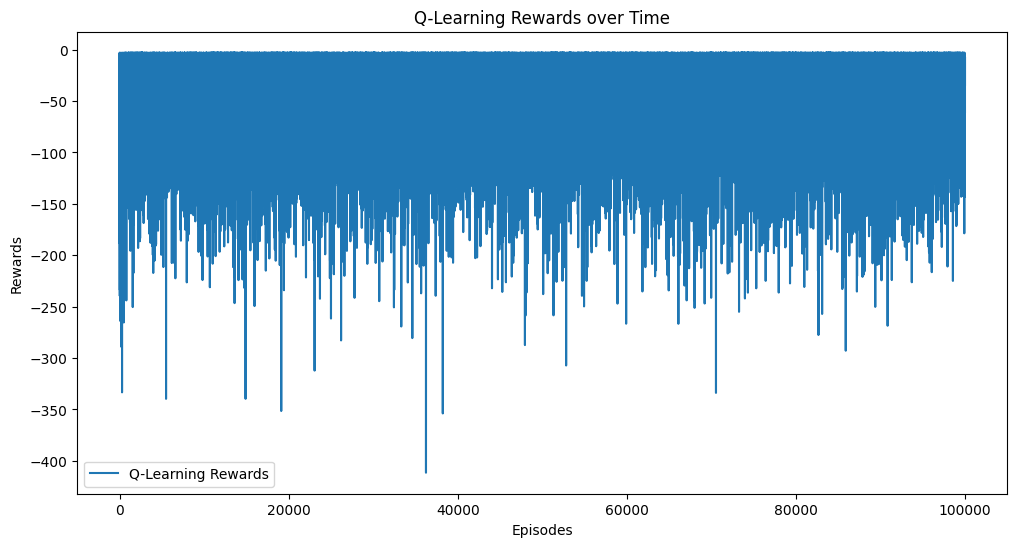

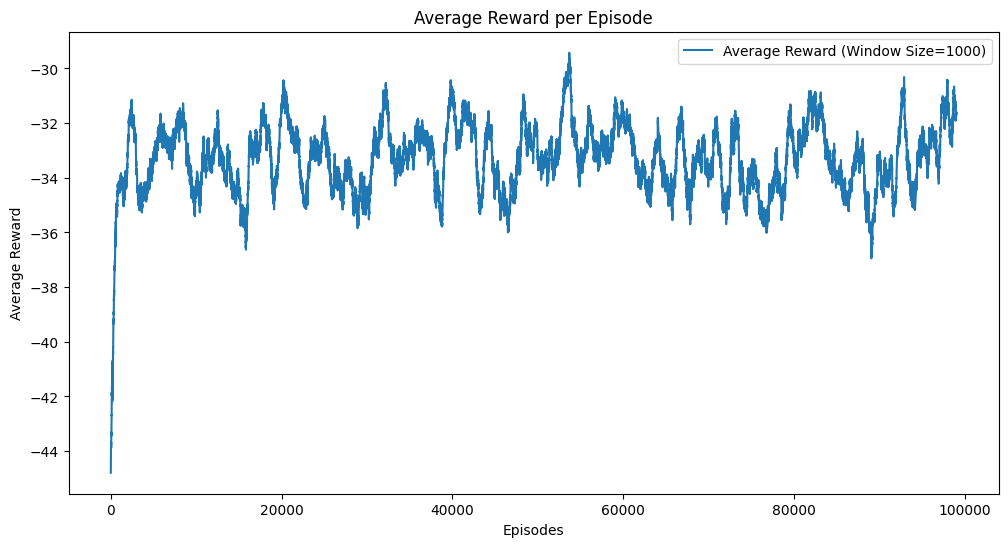

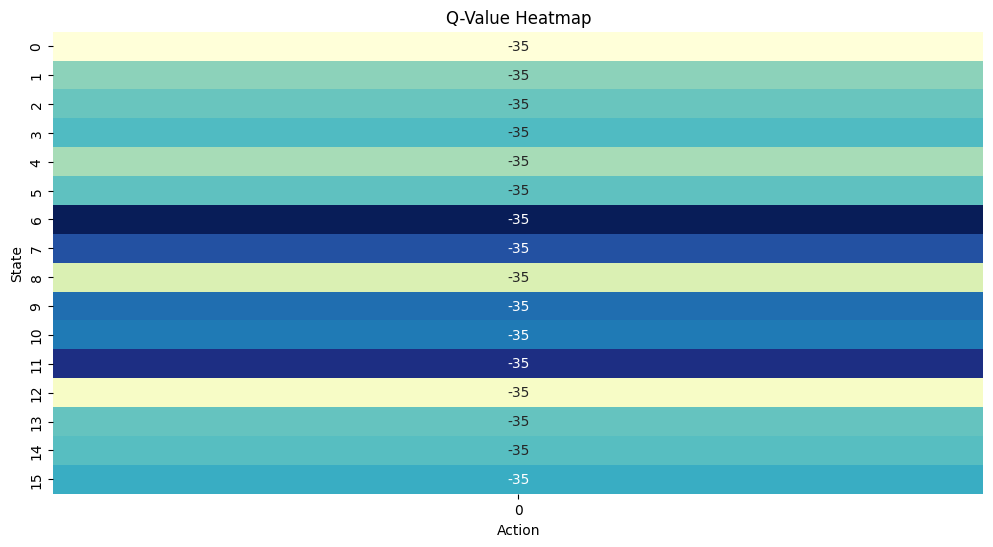

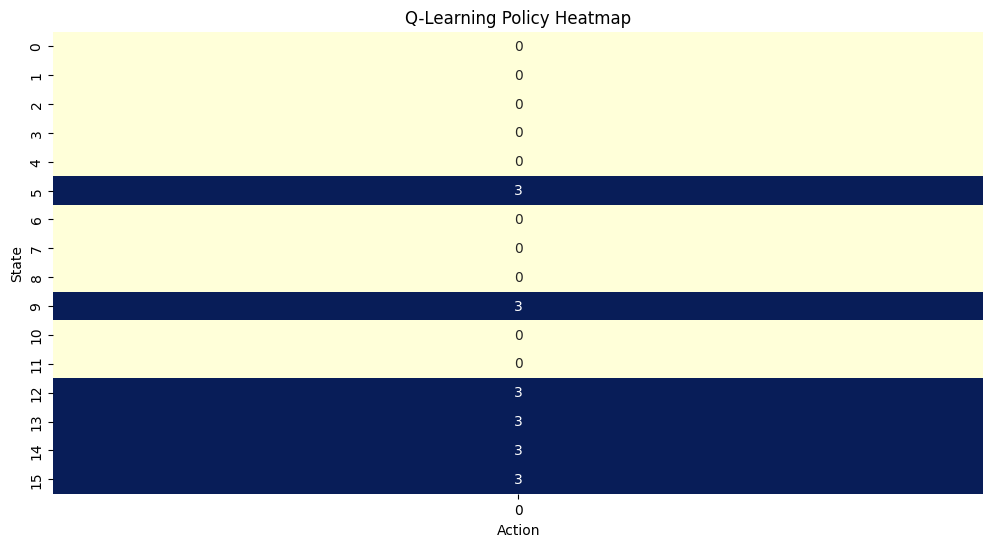

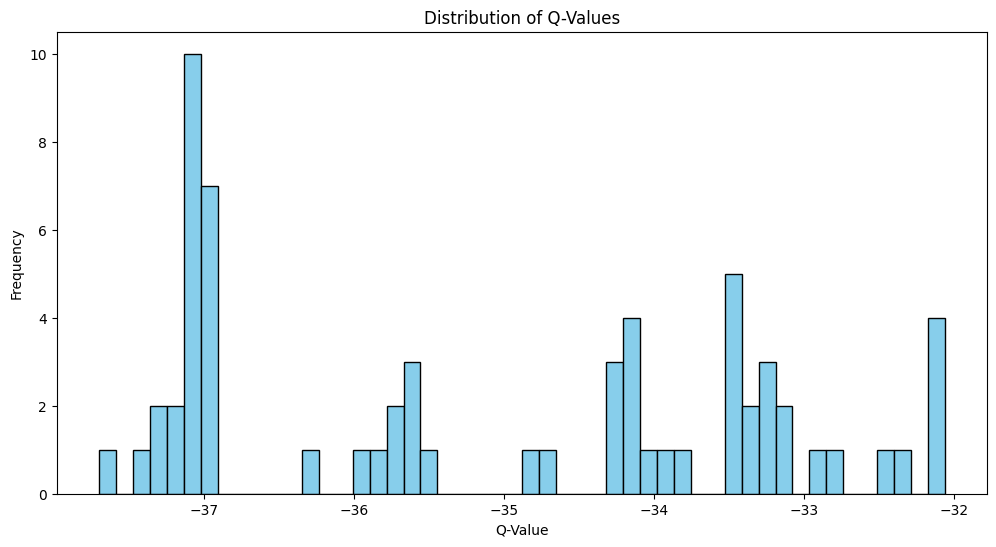

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

class VNFEnvironment:
    def __init__(self, M, N, C, trans_probs, w_on, w_r, w_SLA, cost_on, cost_r, cost_SLA):
        self.M = M  # Number of Physical Nodes
        self.N = N  # Number of VNFs
        self.C = C  # Capacity of Node
        self.trans_probs = trans_probs  # Transition Probabilities
        self.w_on = w_on  # Weight of power cost
        self.w_r = w_r  # Weight of reconfiguration cost
        self.w_SLA = w_SLA  # Weight of SLA cost
        self.cost_on = cost_on  # Power cost
        self.cost_r = cost_r  # Reconfiguration cost
        self.cost_SLA = cost_SLA  # SLA violation cost

        self.state = {
            'locations': np.random.choice(range(self.M), self.N),
            'demands': np.random.choice(['H', 'L'], self.N)
        }

        self.state_to_index_map = {}
        self.index_to_state_map = {}
        self._generate_state_mappings()

    def _generate_state_mappings(self):
        state_idx = 0
        for locations in itertools.product(range(self.M), repeat=self.N):
            for demands in itertools.product(['H', 'L'], repeat=self.N):
                state = {'locations': list(locations), 'demands': list(demands)}
                self.state_to_index_map[self._state_to_tuple(state)] = state_idx
                self.index_to_state_map[state_idx] = state
                state_idx += 1

    def _state_to_tuple(self, state):
        return (tuple(state['locations']), tuple(state['demands']))

    def state_to_index(self, state):
        return self.state_to_index_map[self._state_to_tuple(state)]

    def index_to_state(self, index):
        return self.index_to_state_map[index]

    def reset(self):
        self.state = {
            'locations': np.random.choice(range(self.M), self.N),
            'demands': np.random.choice(['H', 'L'], self.N)
        }
        return self.state

    def next_step(self, state, action):
        new_locations = action
        active_nodes = len(set(new_locations))
        Cost_ON = self.cost_on * active_nodes
        Cost_R = self.cost_r * sum(np.array(state['locations']) != np.array(new_locations))

        Cost_SLA = 0
        demands = [0] * self.M
        for i in range(self.N):
            if state['demands'][i] == 'H':
                demands[new_locations[i]] += 1
            else:
                demands[new_locations[i]] += 0.5

        for j in range(self.M):
            if demands[j] > self.C:
                Cost_SLA += self.cost_SLA * (demands[j] - self.C)**2

        total_cost = self.w_on * Cost_ON + self.w_r * Cost_R + self.w_SLA * Cost_SLA
        reward = -total_cost

        new_demands = []
        for i in range(self.N):
            if state['demands'][i] == 'H':
                new_demands.append('H' if np.random.rand() < self.trans_probs[i, 0] else 'L')
            else:
                new_demands.append('L' if np.random.rand() < self.trans_probs[i, 2] else 'H')

        new_state = {'locations': new_locations, 'demands': new_demands}

        return new_state, reward

class QLAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.actions = list(itertools.product(range(env.M), repeat=env.N))
        self.q_table = np.zeros((len(env.state_to_index_map), len(self.actions)))

    def choose_action(self, state_idx):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions))
        return np.argmax(self.q_table[state_idx])

    def train(self, episodes=1000):
        rewards = []  # List to store rewards for each episode
        for episode in range(episodes):
            self.env.reset()
            state = self.env.state
            state_idx = self.env.state_to_index(state)
            done = False
            total_reward = 0  # Track total reward for the episode

            while not done:
                action_idx = self.choose_action(state_idx)
                action = self.actions[action_idx]
                next_state, reward = self.env.next_step(state, action)
                next_state_idx = self.env.state_to_index(next_state)

                best_next_action_idx = np.argmax(self.q_table[next_state_idx])
                td_target = reward + self.gamma * self.q_table[next_state_idx, best_next_action_idx]
                td_error = td_target - self.q_table[state_idx, action_idx]

                self.q_table[state_idx, action_idx] += self.alpha * td_error

                state = next_state
                state_idx = next_state_idx

                total_reward += reward

                if np.random.rand() < 0.1:  # Probability to end episode (optional for finite episodes)
                    done = True

            rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return rewards

    def get_policy(self):
        policy = np.zeros(len(self.env.state_to_index_map), dtype=int)
        for state_idx in range(len(self.env.state_to_index_map)):
            policy[state_idx] = np.argmax(self.q_table[state_idx])
        return policy

if __name__ == "__main__":
    np.random.seed(42)

    N = 2
    M = 2

    trans_probs = np.tile([0.6, 0.5, 0.5, 0.6], (N, 1))

    w_ON = 3
    w_R = 1
    w_SLA = 1

    c_ON = 1
    c_R = 1
    c_SLA = 1

    env = VNFEnvironment(
        M=M, N=N, C=1.2,
        trans_probs=trans_probs,
        w_on=w_ON, w_r=w_R, w_SLA=w_SLA,
        cost_on=c_ON, cost_r=c_R, cost_SLA=c_SLA
    )

    q_agent = QLAgent(env)
    q_learning_rewards = q_agent.train(episodes=100000)
    q_optimal_policy = q_agent.get_policy()

    # Plot convergence of Q-learning
    plt.figure(figsize=(12, 6))
    plt.plot(q_learning_rewards, label='Q-Learning Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Q-Learning Rewards over Time')
    plt.legend()
    plt.show()

    # Plot average reward per episode
    window_size = 1000
    avg_rewards = np.convolve(q_learning_rewards, np.ones(window_size) / window_size, mode='valid')

    plt.figure(figsize=(12, 6))
    plt.plot(avg_rewards, label=f'Average Reward (Window Size={window_size})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode')
    plt.legend()
    plt.show()

    # Create heatmap for Q-values
    q_value_map = np.mean(q_agent.q_table, axis=1).reshape((len(env.state_to_index_map), -1))

    plt.figure(figsize=(12, 6))
    sns.heatmap(q_value_map, annot=True, cmap="YlGnBu", cbar=False)
    plt.title('Q-Value Heatmap')
    plt.xlabel('Action')
    plt.ylabel('State')
    plt.show()

    # Create heatmap for policies
    q_policy_map = np.zeros((len(env.state_to_index_map),))

    for state_idx in range(len(env.state_to_index_map)):
        q_policy_map[state_idx] = q_optimal_policy[state_idx]

    plt.figure(figsize=(12, 6))
    sns.heatmap(q_policy_map.reshape((len(env.state_to_index_map), -1)), annot=True, cmap="YlGnBu", cbar=False)
    plt.title('Q-Learning Policy Heatmap')
    plt.xlabel('Action')
    plt.ylabel('State')
    plt.show()

    # Distribution of Q-values
    plt.figure(figsize=(12, 6))
    plt.hist(q_agent.q_table.flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Q-Values')
    plt.xlabel('Q-Value')
    plt.ylabel('Frequency')
    plt.show()


DQN network | task 3

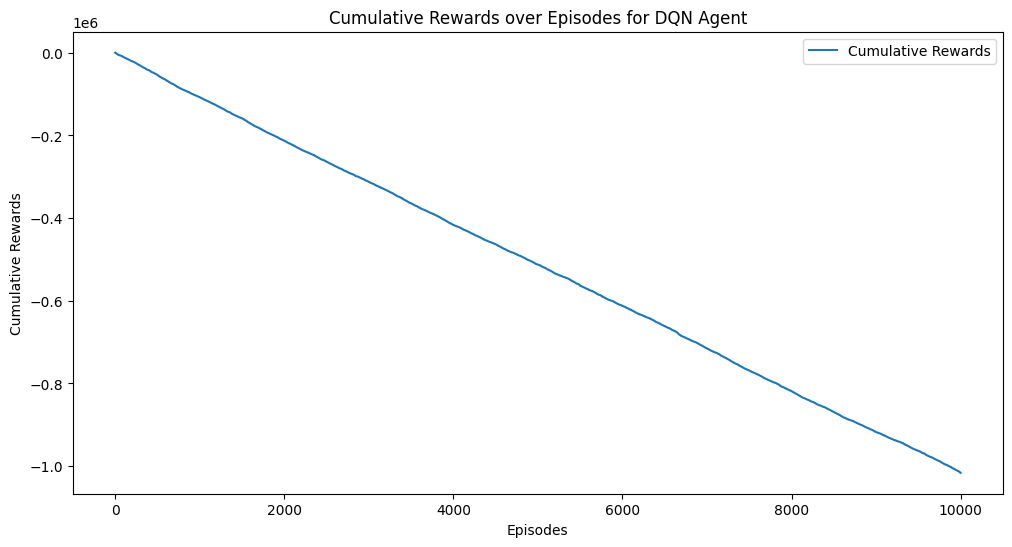

Optimal Policy:
Action: (1, 1) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (1, 1) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (1, 1) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) | Action: (0, 0) 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import itertools
import matplotlib.pyplot as plt


class VNFEnvironment:
    def __init__(self, M, N, C, w_on, w_r, w_SLA, cost_on, cost_r, cost_SLA):
        self.M = M  # Number of Physical Nodes
        self.N = N  # Number of VNFs
        self.C = C  # Capacity of Node
        self.w_on = w_on  # Weight of power cost
        self.w_r = w_r  # Weight of reconfiguration cost
        self.w_SLA = w_SLA  # Weight of SLA cost
        self.cost_on = cost_on  # Power cost
        self.cost_r = cost_r  # Reconfiguration cost
        self.cost_SLA = cost_SLA  # SLA violation cost

        self.state = {
            'locations': np.random.choice(range(self.M), self.N),
            'demands': np.random.rand(self.N)  # Continuous demands
        }

    def reset(self):
        self.state = {
            'locations': np.random.choice(range(self.M), self.N),
            'demands': np.random.rand(self.N)  # Random initial demands
        }
        return np.concatenate((self.state['locations'], self.state['demands']))

    def next_step(self, state, action):
        locations = state[:self.N]
        demands = state[self.N:]

        new_locations = action
        active_nodes = len(set(new_locations))
        Cost_ON = self.cost_on * active_nodes
        Cost_R = self.cost_r * sum(np.array(locations) != np.array(new_locations))

        Cost_SLA = 0
        demand_distribution = [0] * self.M
        for i in range(self.N):
            demand_distribution[new_locations[i]] += demands[i]

        for j in range(self.M):
            if demand_distribution[j] > self.C:
                Cost_SLA += self.cost_SLA * (demand_distribution[j] - self.C)**2

        total_cost = self.w_on * Cost_ON + self.w_r * Cost_R + self.w_SLA * Cost_SLA
        reward = -total_cost

        new_demands = np.random.rand(self.N)  # New random demands

        new_state = np.concatenate((new_locations, new_demands))

        return new_state, reward

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, env, input_dim, output_dim, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64, memory_size=10000):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)

        self.device = torch.device("cpu")

        self.model = DQN(input_dim, output_dim).to(self.device)
        self.target_model = DQN(input_dim, output_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions))
        state = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return q_values.argmax().item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, episodes=10000):
            episode_rewards = []  # List to store rewards per episode
            for episode in range(episodes):
                state = self.env.reset()
                done = False
                MAX_STEPS = 100  # Maximum steps per episode
                step = 0
                total_reward = 0  # To accumulate rewards for this episode
                while not done and step < MAX_STEPS:
                    action_idx = self.choose_action(state)
                    action = self.actions[action_idx]
                    next_state, reward = self.env.next_step(state, action)
                    done = np.random.rand() < 0.1
                    step += 1
                    self.store_transition(state, action_idx, reward, next_state, done)
                    state = next_state
                    self.train_step()
                    total_reward += reward  # Accumulate reward

                episode_rewards.append(total_reward)  # Store total reward for this episode

                if episode % 10 == 0:
                    self.update_target_network()

            return episode_rewards  # Return the rewards for plotting

    def get_policy(self):
        policy = {}
        for locations in itertools.product(range(self.env.M), repeat=self.env.N):
            for demand_combination in itertools.product(np.arange(0, 1.1, 0.1), repeat=self.env.N):
                state_array = np.concatenate((locations, demand_combination))
                state_tensor = torch.FloatTensor(state_array).to(self.device)
                with torch.no_grad():
                    action_idx = self.model(state_tensor).argmax().item()
                policy[(tuple(locations), tuple(demand_combination))] = action_idx
        return policy

    def print_optimal_policy(self):
        # Get the optimal policy
        policy = self.get_policy()

        print("Optimal Policy:")
        for state_tuple, action_idx in policy.items():
            locations, demands = state_tuple
            action = self.actions[action_idx]

            # Print the state and the corresponding action
            print(f"Action: {action}",end=' | ')


if __name__ == "__main__":
    np.random.seed(42)

    N = 2
    M = 2

    w_ON = 10
    w_R = 1
    w_SLA = 1

    c_ON = 1
    c_R = 1
    c_SLA = 1

    env = VNFEnvironment(
        M=M, N=N, C=1.2,
        w_on=w_ON, w_r=w_R, w_SLA=w_SLA,
        cost_on=c_ON, cost_r=c_R, cost_SLA=c_SLA
    )

    state_dim = M + N  # Locations + Demands
    action_dim = M**N  # All possible actions
    actions = list(itertools.product(range(M), repeat=N))

    dqn_agent = DQNAgent(env, input_dim=state_dim, output_dim=action_dim)
    dqn_agent.actions = actions
    rewards = dqn_agent.train(episodes=10000)

    # Plotting the cumulative rewards
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(rewards)), np.cumsum(rewards), label='Cumulative Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Cumulative Rewards over Episodes for DQN Agent')
    plt.legend()
    plt.show()

    optimal_policy = dqn_agent.get_policy()
    dqn_agent.print_optimal_policy()